This guide shows how to train and infer [Clay Foundation Model](https://clay-foundation.github.io/model/index.html) for classification task using our API.

<a target="_blank" href="https://colab.research.google.com/github/greenlensai/docs/blob/main/api-reference/train-a-classifier/train-a-classifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
API_URL = "https://api.greenlens.world"
HEADERS = {"Content-Type": "application/json"}

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

lat, lon = 37.30939, -8.57207
start, end = "2018-07-01", "2018-09-01"

In [ ]:
!pip install pystac-client geopandas stackstac

## Loading data

This step completely copies data preparation step from the [Clay example notebook](https://clay-foundation.github.io/model/tutorials/clay-v1-wall-to-wall.html) and you probably don't need it if you have your own data. If that's the case, jump to the next section.

If you need more elaboration on what's going on visit original source.

Found 12 items


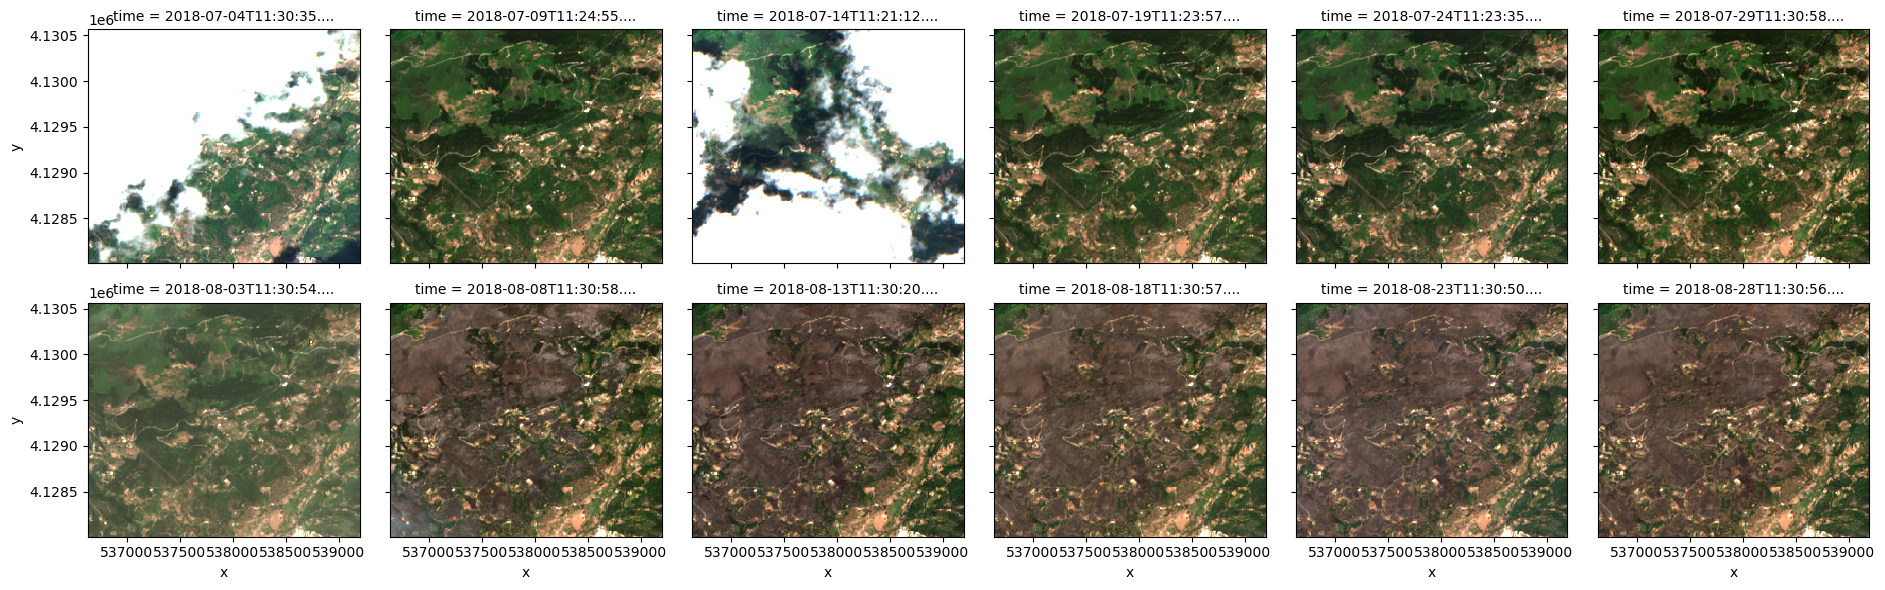

In [3]:
import pystac_client
import geopandas as gpd
import pandas as pd
from shapely import Point
import stackstac
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np

catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-5, lat - 1e-5, lon + 1e-5, lat + 1e-5),
    max_items=100,
    query={"eo:cloud_cover": {"lt": 80}},
)

all_items = search.item_collection()

items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

epsg = items[0].properties["proj:epsg"]

poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

size = 256
gsd = 10
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float32",
    rescale=False,
    fill_value=0,
    assets=["blue", "green", "red", "nir"],
    resampling=Resampling.nearest,
)

stack = stack.compute()

stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)
plt.show()

In [4]:
labels = np.array([0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2])

train_idxs = [0, 1, 3, 4, 7, 8, 9]
test_idxs = [2, 5, 6, 10, 11]

train_labels = labels[train_idxs].tolist()
test_labels = labels[test_idxs].tolist()

## Train model

Now we need to load data to the format which is accepted by our API. Essentially, it is raw pixels data from all bands with some metadata.

You can check detailed endpoint specification [in the docs](https://docs.greenlens.world/api-reference/train/train-classification-model).

In [5]:
import requests
import numpy as np
from pprint import pprint

In [6]:
images = []
for image in stack:
    images.append(
        {
            "bands": image.band.values.tolist(),
            "gsd": image.gsd.values.item(),
            "pixels": image.values.tolist(),
            "platform": COLLECTION,
            "point": [lat, lon],
            "timestamp": image.time.values.astype('datetime64[s]').astype(np.int64).item(),
        }
    )
    
train_images = [image for i, image in enumerate(images) if i in train_idxs]
test_images = [image for i, image in enumerate(images) if i in test_idxs]

In [7]:
url = API_URL + "/train/classification"
payload = {"images": train_images, "labels": train_labels}
response = requests.request("POST", url, json=payload, headers=HEADERS)
if response.status_code != 200:
    print(f"{response.status_code}: {response.json()}")
else:
    data = response.json()
    model_id, train_details = data["model_id"], data["train_details"]
    print(f"Model id: '{model_id}'")
    pprint(train_details)

Model id: 'classification_7_HVAMP'
{'C': 1.0,
 '_dual_coef_': [[1.0,
                  -0.0,
                  -0.0,
                  -1.0,
                  -0.8156204184417959,
                  -0.1843795815582041,
                  -0.0],
                 [1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0]],
 '_gamma': 0.09169353742221836,
 '_intercept_': [-0.29456670582294464,
                 -0.2557448372244835,
                 0.008118540048599243],
 '_n_support': [1, 3, 3],
 '_num_iter': [1, 2, 3],
 '_probA': [],
 '_probB': [],
 '_sparse': False,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'class_weight_': [1.0, 1.0, 1.0],
 'classes_': [0, 1, 2],
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'dual_coef_': [[1.0,
                 -0.0,
                 -0.0,
                 -1.0,
                 -0.8156204184417959,
                 -0.1843795815582041,
                 -0.0],
                [1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0]],
 'epsilon': 0

## Run inference

For inference we need only images.

You can check detailed endpoint specification [in the docs](https://docs.greenlens.world/api-reference/inference/infer-classification-model).

In [8]:
url = API_URL + "/inference/classification"
payload = {"images": test_images, "model_id": model_id}
response = requests.request("POST", url, json=payload, headers=HEADERS)
if response.status_code != 200:
    print(f"{response.status_code}: {response.json()}")
else:
    predicted_labels = response.json()["labels"]

In [9]:
match = np.sum(np.array(test_labels) == np.array(predicted_labels))
print(f"Matched {match} out of {len(test_labels)} correctly")

Matched 5 out of 5 correctly
